In [2]:
# =============================================================================
# DS-785 Capstone | Hospital Readmission (UCI Diabetes) 
# Author: Jayanth Yerragudi
# =============================================================================
# ORDER
# 0) Import the CSV file diabates_data.csv
# 1) Define config data and lists for handling the data
# 2) Load data into pandas dataframe & create target variable
# 3) Initial Data Profiling 
# 4) Identify and handle Missing values, variable reduction, formatting
# 5) Outlier detection and correction if applicable
# 6) Scaling numeric features (RobustScaler) and keep original unscaled features
# 7) Encoding categorical variables
# 7.1) Encode categoricals:
#       - Medication columns: ordinal map (No=0, Steady=1, Up=2, Down=-1)
#       - Diag columns : grouping by ICD-9 coding 
#       - Others: one-hot with drop='first'
# 8)  Descriptive stats & key plots (simple, readable)  
# 9)  Inferential stats (t-test, chi-square)           
# 10) Correlation focus (target vs top features)      
# 11) Drop unscaled features after checking correlation and inferential stats
# 12) Feature Engineering (total_visits, meds_per_day, meds_changed_count, etc.)
# 12) PCA diagnostic (report variance, no modeling)    
# 13) Train/Val/Test split + SMOTE for class imbalance **training data only** 
# 14) Baseline model - Logistic Regression - check the metrics
# 15) Advanced models (RandomForest, LightGBM) + metrics 
# =============================================================================


In [3]:
# 0) Imports & helpers
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             roc_curve, precision_recall_fscore_support, accuracy_score, recall_score, f1_score, precision_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from scipy import stats
from scipy.stats import chi2_contingency

import seaborn as sns

# Optional: SMOTE (install imbalanced-learn if needed)
try:
    from imblearn.over_sampling import SMOTE
    IMB_OK = True
except:
    IMB_OK = False


In [4]:
# 1) Config & paths
CONFIG = {
    "csv_path": "C:/Users/jxyer/Documents/Jayanth/Data Science/DS785_CAPSTONE/diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv",  
    "outlier_treatment": "cap",     # {"cap","remove","none"}
    "outlier_cap_quantiles": (0.01, 0.99),
    "rare_specialty_threshold": 0.01,
    "rare_diag_threshold": 0.01,
    "long_stay_days": 7,
    "ed_threshold": 2,
    "inpt_threshold": 1,
    "pca_components": 2,
    "test_size": 0.2, #20% 
    "val_size": 0.1, #10%                # of the TRAIN fold (i.e., 0.1 of remaining after test)
    "random_state": 42
}

In [5]:
# 2) Load data & create target variable readmitted_flag
df = pd.read_csv(CONFIG["csv_path"])
df.head(20).T


#  replace ? with NaN
df.replace({"?": np.nan, "None": np.nan, "none": np.nan, "NA": np.nan}, inplace=True)

# target variable: readmitted_flag = 1 if "<30" else 0
assert "readmitted" in df.columns, "Expected 'readmitted' in columns"
df["readmitted_flag"] = np.where(df["readmitted"].str.upper().eq("<30"), 1, 0)

print(df.shape, df["readmitted_flag"].mean().round(3))
df.head(20).T

(101766, 51) 0.112


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738,28236,36900,40926,42570,62256,73578,77076,84222,89682,148530
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939,89869032,77391171,85504905,77586282,49726791,86328819,92519352,108662661,107389323,69422211
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,AfricanAmerican,NaN
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,Female,Male,Female,Male,Female,Male,Male,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),[40-50),[60-70),[40-50),[80-90),[60-70),[60-70),[50-60),[50-60),[70-80),[70-80)
weight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_type_id,6,1,1,1,1,2,3,1,2,3,1,2,1,1,3,1,1,1,1,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3,1,1,3,6,1,3,1,1,1,6
admission_source_id,1,7,7,7,7,2,2,7,4,4,7,4,7,7,2,7,7,7,7,2
time_in_hospital,1,3,2,2,1,3,4,5,13,12,9,7,7,10,1,12,4,3,5,6


In [6]:
# 3) INITIAL DATA PROFILING

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)

# There are 101,766 records with 51 variables
# checking few object type variables individually for unique values to be cleaned up / encode categorical variables

# Inspect first 50 rows of data

df.head(50)

unique_race = df['race'].value_counts()
print(unique_race) # there are 2273 records with ?, cleanup and replace as Unknown 

unique_gender = df['gender'].value_counts()
print(unique_gender) 

unique_age = df['age'].value_counts()
print(unique_age)

unique_weight = df['weight'].value_counts()
print(unique_weight)

unique_payer_code = df['payer_code'].value_counts()
print(unique_payer_code)

unique_medical_specialty = df['medical_specialty'].value_counts()
print(unique_medical_specialty)

unique_max_glu_serum = df['max_glu_serum'].value_counts()
print(unique_max_glu_serum)

unique_A1Cresult = df['A1Cresult'].value_counts()
print(unique_A1Cresult)

Shape: (101766, 51)

Dtypes:
 encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide           

In [7]:
# 4) Identify and handle Missing values, variable reduction, formatting
# drop obvious IDs, columns with very high missing values as they won't help with the predictions
# identifier columns such as encounter_id and patient_nbr 
df.drop('encounter_id', axis=1, inplace=True)
df.drop('patient_nbr', axis=1, inplace=True)


# check all other variables for missing values
# used the code below from -- https://www.kaggle.com/code/hkubra/predicting-the-readmission-of-diabetic-patient-s?scriptVersionId=49983745&cellId=24 
def Missing_Values(df):
    variable_name = []
    total_value = []
    total_missing_value = []
    missing_value_rate = []
    unique_value_list = []
    total_unique_value = []
    data_type = []
    
    for col in df.columns:
        variable_name.append(col)
        data_type.append(df[col].dtype)
        total_value.append(df[col].shape[0])
        total_missing_value.append(df[col].isnull().sum())
        missing_value_rate.append(round(df[col].isnull().sum()/df[col].shape[0],4))
        unique_value_list.append(df[col].unique())
        total_unique_value.append(len(df[col].unique()))
        
    missing_data=pd.DataFrame({"Variable":variable_name,\
                               "#_Total_Value":total_value,\
                               "#_Total_Missing_Value":total_missing_value,\
                               "%_Missing_Value_Rate":missing_value_rate,\
                               "Data_Type":data_type,"Unique_Value":unique_value_list,\
                               "Total_Unique_Value":total_unique_value
                              })
    
    missing_data = missing_data.set_index("Variable")
    return missing_data.sort_values("#_Total_Missing_Value",ascending=False)

df_info = Missing_Values(df)
df_info

,#_Total_Value,#_Total_Missing_Value,%_Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
Variable,,,,,,
weight,101766,98569,0.9686,object,"[nan, [75-100), [50-75), [0-25), [100-125), [2...",10
max_glu_serum,101766,96420,0.9475,object,"[nan, >300, Norm, >200]",4
A1Cresult,101766,84748,0.8328,object,"[nan, >7, >8, Norm]",4
medical_specialty,101766,49949,0.4908,object,"[Pediatrics-Endocrinology, nan, InternalMedici...",73
payer_code,101766,40256,0.3956,object,"[nan, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, ...",18
race,101766,2273,0.0223,object,"[Caucasian, AfricanAmerican, nan, Other, Asian...",6
diag_3,101766,1423,0.0140,object,"[nan, 255, V27, 403, 250, V45, 38, 486, 996, 1...",790
diag_2,101766,358,0.0035,object,"[nan, 250.01, 250, 250.43, 157, 411, 492, 427,...",749
diag_1,101766,21,0.0002,object,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,...",717


In [8]:

#VARIABLE REDUCTION
#The weight variable had extensive missing values (over 97%), making it unsuitable for predictive modeling. 
#It was therefore excluded from further analysis.
unique_weight = df['weight'].value_counts()
print(unique_weight)  # most of the records have ? and decided to drop this column as it won't have significance in the predictions with lot of unknown values
df.drop('weight', axis = 1, inplace = True)

# payer_code variable is not considered relevant to the outcome (this is as per the original publication) so will be removed
unique_payer_code = df['payer_code'].value_counts()
print(unique_payer_code)  # most of the records have ? and decided to drop this column as it won't have significance in the predictions 
#with lot of unknown values
df.drop('payer_code', axis = 1, inplace = True)

weight
[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: count, dtype: int64
payer_code
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64


In [9]:
# cleanup age variable from bins like "[70-80)" to midpoint value 75 for all groups
def age_to_midpoint(x):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if s.startswith("[") and s.endswith(")") and "-" in s:
        lo, hi = s[1:-1].split("-")
        try: return (float(lo) + float(hi)) / 2.0
        except: return np.nan
    return np.nan

if "age" in df.columns:
    df["age_mid"] = df["age"].apply(age_to_midpoint)

# converting the age range to midpoint value helps convert the range to a numeric value
# it roughly represents the age group for the patient

df.drop('age', axis=1, inplace=True)


df_info = Missing_Values(df)
df_info
#df.head(20).T

,#_Total_Value,#_Total_Missing_Value,%_Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
Variable,,,,,,
max_glu_serum,101766,96420,0.9475,object,"[nan, >300, Norm, >200]",4
A1Cresult,101766,84748,0.8328,object,"[nan, >7, >8, Norm]",4
medical_specialty,101766,49949,0.4908,object,"[Pediatrics-Endocrinology, nan, InternalMedici...",73
race,101766,2273,0.0223,object,"[Caucasian, AfricanAmerican, nan, Other, Asian...",6
diag_3,101766,1423,0.0140,object,"[nan, 255, V27, 403, 250, V45, 38, 486, 996, 1...",790
diag_2,101766,358,0.0035,object,"[nan, 250.01, 250, 250.43, 157, 411, 492, 427,...",749
diag_1,101766,21,0.0002,object,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,...",717
time_in_hospital,101766,0,0.0000,int64,"[1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]",14
admission_source_id,101766,0,0.0000,int64,"[1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22...",17


In [41]:
# impute numeric missing
# apply median value for missing values for numeric variables using SimpleImputer function
num_cols_raw = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols_raw if c != "readmitted_flag"]
if num_cols:
    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])

# fill categorical NAs with "Unknown" (before grouping & encoding)
cat_cols = df.select_dtypes(exclude=[np.number]).columns
df[cat_cols] = df[cat_cols].fillna("Unknown")

df.head(10)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted_flag,age_mid,...,diag_3_grouped_Other,diag_3_grouped_Respiratory,diag_3_grouped_Skin/Subcutaneous,diag_3_grouped_Supplementary classification,diag_3_grouped_Unknown,total_visits,meds_per_day,long_stay_flag,frequent_ed_flag,prior_inpt_flag
0,-0.75,-0.115385,-0.5,-1.2,0.0,0.0,0.0,-2.000000,0,-2.0,...,False,False,False,False,True,0.0,-1.200000,0.0,0.0,0.0
1,-0.25,0.576923,-0.5,0.3,0.0,0.0,0.0,0.333333,0,-2.0,...,False,False,False,False,False,0.0,0.300000,0.0,0.0,0.0
2,-0.50,-1.269231,2.0,-0.2,2.0,0.0,1.0,-0.666667,0,-2.0,...,False,False,False,True,False,3.0,-0.200000,0.0,0.0,1.0
3,-0.50,0.000000,0.0,0.1,0.0,0.0,0.0,-0.333333,0,-1.5,...,False,False,False,False,False,0.0,0.100000,0.0,0.0,0.0
4,-0.75,0.269231,-0.5,-0.7,0.0,0.0,0.0,-1.000000,0,-1.0,...,False,False,False,False,False,0.0,-0.700000,0.0,0.0,0.0
5,-0.25,-0.500000,2.5,0.1,0.0,0.0,0.0,0.333333,0,-0.5,...,False,False,False,False,False,0.0,0.100000,0.0,0.0,0.0
6,0.00,1.000000,0.0,0.6,0.0,0.0,0.0,-0.333333,0,0.0,...,False,False,False,True,False,0.0,0.600000,0.0,0.0,0.0
7,0.25,1.115385,-0.5,-0.3,0.0,0.0,0.0,0.000000,0,0.5,...,False,False,False,False,False,0.0,-0.300000,0.0,0.0,0.0
8,2.25,0.923077,0.5,1.3,0.0,0.0,0.0,0.000000,0,1.0,...,False,False,False,False,False,0.0,0.577778,1.0,0.0,0.0
9,2.00,-0.423077,1.0,0.3,0.0,0.0,0.0,0.000000,0,1.5,...,False,True,False,False,False,0.0,0.150000,1.0,0.0,0.0


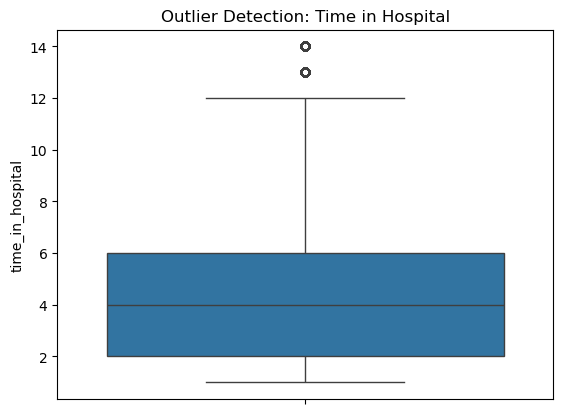

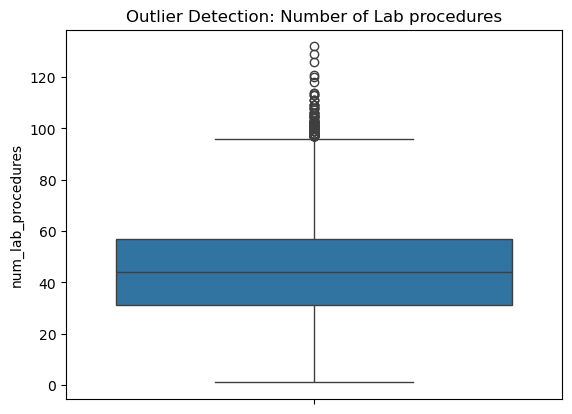

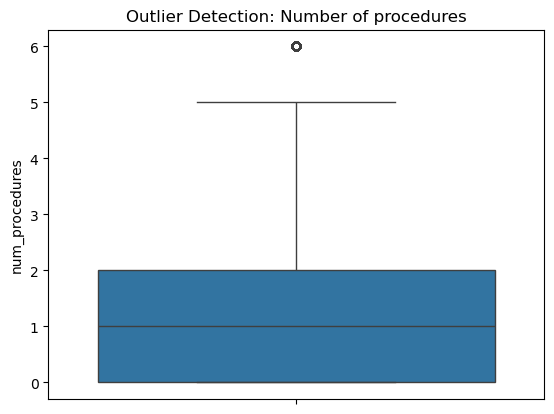

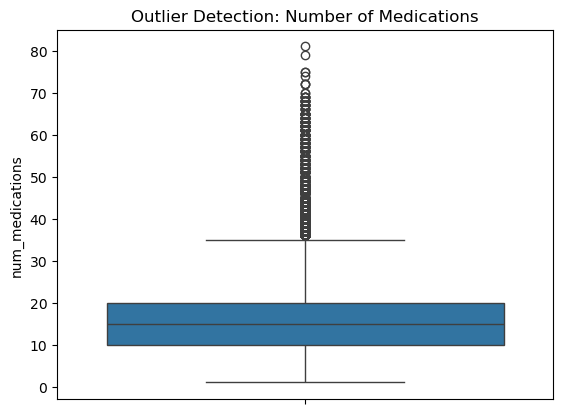

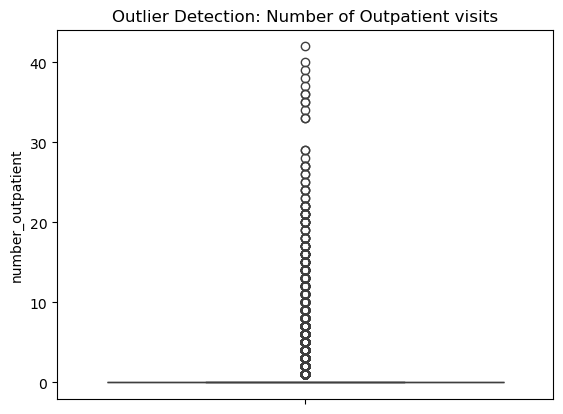

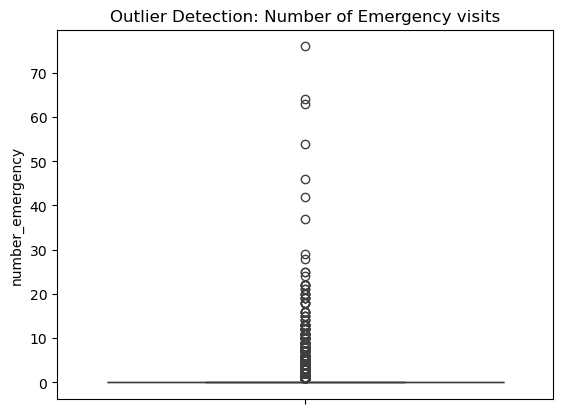

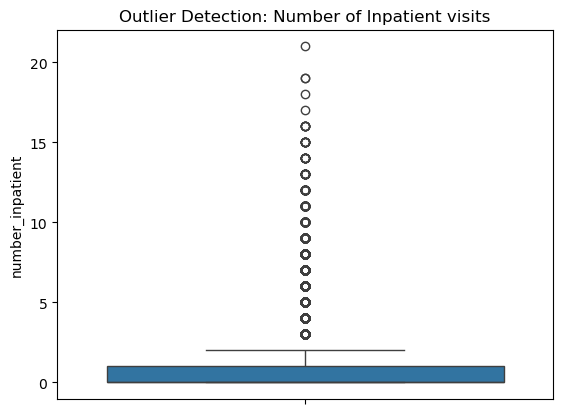

In [11]:
# 4) Outliers detection: first I identified outliers and based on the plots , I will decide whether to cap the outliers, remove the outliers
# or do nothing

# outliers are data points in the dataset that deviate significantly from the rest of the data i.e. unusually high or low values
# For the numerical datatypes in the dataset, outlier detection is important as these can 
# skew averages and standard deviations resulting in reduced model accuracy and interpretability

# box plots are commonly used for detecting outliers
# the variables which I checked for outlier detection are 

# time_in_hospital, 
# num_lab_procedures, 
# num_procedures,
# num_medications,
# number_outpatient,
# number_emergency,
# number_inpatient

df['time_in_hospital'].describe() # max value 14
sns.boxplot(df['time_in_hospital'])
plt.title("Outlier Detection: Time in Hospital")
plt.show() #The variable time_in_hospital shows a few outliers at 12 and 14 days, which indicate longer-than-usual hospital stays. These could be valid clinical cases but may influence model training. 
 #To ensure stability, I will scale this variable during preprocessing


df['num_lab_procedures'].describe() # max value 132 , mean value 42
sns.boxplot(df['num_lab_procedures'])
plt.title("Outlier Detection: Number of Lab procedures")
plt.show() #The variable num_lab_procedures shows lot of outliers after 100, which could indicate that few complex cases might require more number of labs. 
 #To ensure stability, I will scale this variable during preprocessing

df['num_procedures'].describe() # max 6
sns.boxplot(df['num_procedures'])
plt.title("Outlier Detection: Number of procedures")
plt.show() #The variable num_procedures shows few outliers, which could indicate that few complex cases might require more number of procedures. 
 #To ensure stability, I will scale this variable during preprocessing

df['num_medications'].describe() # max 81 - which indicates either duplicate data or polypharmacy which could be a risk for readmission
sns.boxplot(df['num_medications'])
plt.title("Outlier Detection: Number of Medications")
plt.show() #The variable num_medications shows many outliers after 35, which could indicate polypharmacy which indicates taking several medications each day
 #To ensure stability, I will scale this variable during preprocessing as well as also add a new variable named polypharmacy if medication count > 40 (this step will be performed in feeature engineering in presentation 3)


df['number_outpatient'].describe() # max value 42, mean is 0.3 which indicates lot of skewness
sns.boxplot(df['number_outpatient'])
plt.title("Outlier Detection: Number of Outpatient visits")
plt.show() # This box plot shows very skewed data distribution and majority of the values are 0 which indicates that most of the patients dont have any outpatient visits
# keeping as is for now

df['number_emergency'].describe() # also has heavy skewness which could indicate only high risk or chronic cases , patient with frequent emergency visits could indicate poorly managed chronic condition and might impact the readmission risk
sns.boxplot(df['number_emergency'])
plt.title("Outlier Detection: Number of Emergency visits")
plt.show() # This variable has outliers after 40, indicating most patients dont have emergency visits 
# keeping as is for now

df['number_inpatient'].describe()
sns.boxplot(df['number_inpatient'])
plt.title("Outlier Detection: Number of Inpatient visits")
plt.show() #The variable number_inpatient has max value of 21 which could indicate chronic cases but on an average the number of visits for an inpatient admission is <=4.
# keeping this variable as is could be beneficial to identify high-risk patients

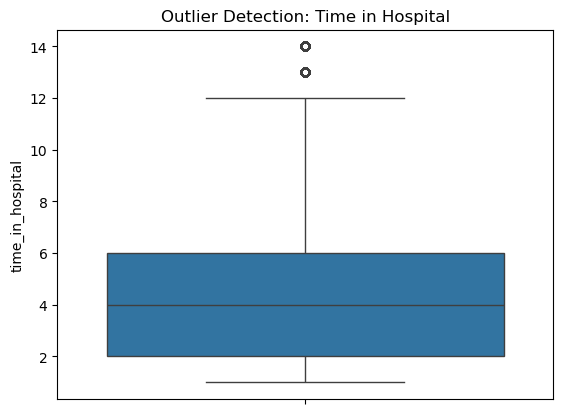

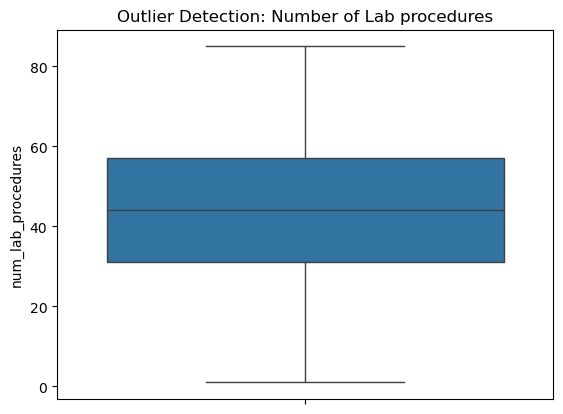

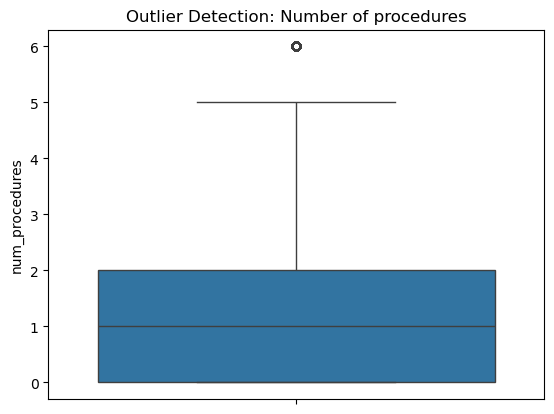

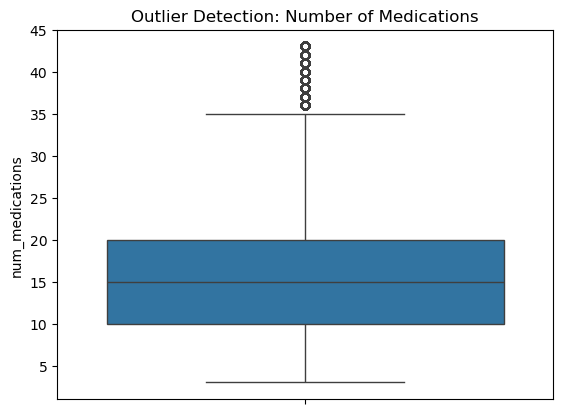

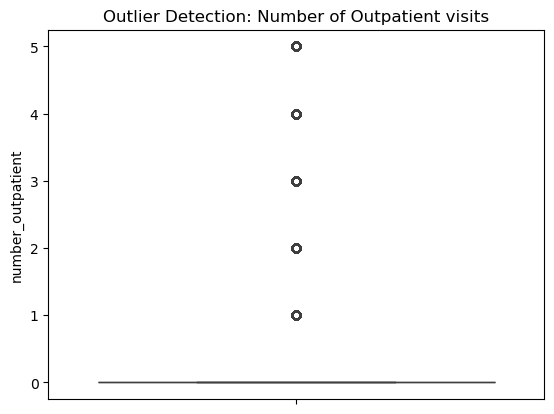

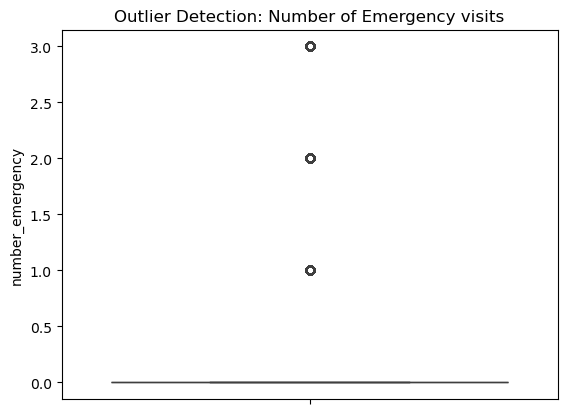

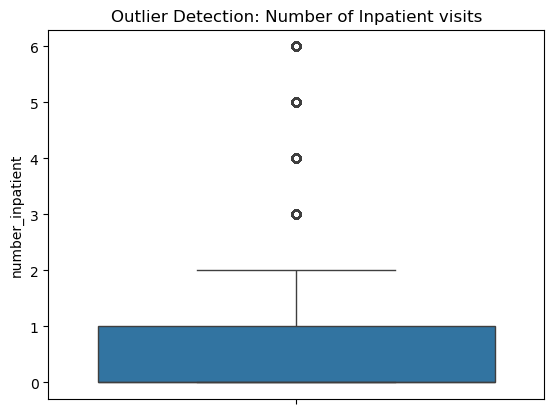

In [12]:
# based on the box plots, I decided to keep the outliers because the outliers could indicate high risk cases and will be needed for modeling

# Defining the function to cap outliers. 
# this function caps the outliers in a numeric column by replacing extremely high or extremely low values with percentile cutoffs.
# lower bound - first percentile
# upper bound - 99th percentile


def cap_outliers(s, q=(0.01,0.99)):
    lo, hi = s.quantile(q[0]), s.quantile(q[1])
    return s.clip(lower=lo, upper=hi)

# applying this function on num_o

if CONFIG["outlier_treatment"] != "none" and num_cols:
    if CONFIG["outlier_treatment"] == "cap":
        for c in num_cols:
            df[c] = cap_outliers(df[c], CONFIG["outlier_cap_quantiles"])
    elif CONFIG["outlier_treatment"] == "remove":
        lo = df[num_cols].quantile(CONFIG["outlier_cap_quantiles"][0])
        hi = df[num_cols].quantile(CONFIG["outlier_cap_quantiles"][1])
        mask = ((df[num_cols] >= lo) & (df[num_cols] <= hi)).all(axis=1)
        df = df[mask].copy()

# check the box plots again after capping
df['time_in_hospital'].describe() 
sns.boxplot(df['time_in_hospital'])
plt.title("Outlier Detection: Time in Hospital")
plt.show() 

df['num_lab_procedures'].describe() 
sns.boxplot(df['num_lab_procedures'])
plt.title("Outlier Detection: Number of Lab procedures")
plt.show() 

df['num_procedures'].describe()
sns.boxplot(df['num_procedures'])
plt.title("Outlier Detection: Number of procedures")
plt.show() 

df['num_medications'].describe() 
sns.boxplot(df['num_medications'])
plt.title("Outlier Detection: Number of Medications")
plt.show() 

df['number_outpatient'].describe() 
sns.boxplot(df['number_outpatient'])
plt.title("Outlier Detection: Number of Outpatient visits")
plt.show() 

df['number_emergency'].describe()
sns.boxplot(df['number_emergency'])
plt.title("Outlier Detection: Number of Emergency visits")
plt.show()

df['number_inpatient'].describe()
sns.boxplot(df['number_inpatient'])
plt.title("Outlier Detection: Number of Inpatient visits")
plt.show()

In [13]:
# 5) Scale numeric (RobustScaler) — minimizes skew impact while preserving rank
if "time_in_hospital" in df.columns:
    df["time_in_hospital_days"] = df["time_in_hospital"].copy()  # raw days backup
scaler = RobustScaler()
if num_cols:
    df[num_cols] = scaler.fit_transform(df[num_cols])


In [14]:
# 6) Group high-card categorical fields
# Formatting and Consistency 

# medical_specialty variable - make it more consistent by grouping into smaller groups 
# Group small categories into 'Other' to simplify
top_specialties = df['medical_specialty'].value_counts().nlargest(10).index
df['medical_specialty_grouped'] = df['medical_specialty'].apply(lambda x: x if x in top_specialties else 'Other')


# ICD-9 grouping for diag_1..3
def group_icd9(code):
    try:
        code = str(code).strip()
        if code in ("", "nan", "Unknown"): return "Unknown"
        if code[0] in ("V","v"): return "Supplementary classification"
        if code[0] in ("E","e"): return "External causes of injury"
        num = float(code)
        if 390 <= num <= 459 or num == 785: return "Circulatory"
        if 460 <= num <= 519 or num == 786: return "Respiratory"
        if 520 <= num <= 579 or num == 787: return "Digestive"
        if 250 <= num < 251:               return "Diabetes"
        if 800 <= num <= 999:              return "Injury"
        if 710 <= num <= 739:              return "Musculoskeletal"
        if 580 <= num <= 629 or num == 788:return "Genitourinary"
        if 140 <= num <= 239:              return "Neoplasms"
        if 240 <= num <= 279 and num != 250: return "Endocrine/Metabolic"
        if 680 <= num <= 709 or num == 782:return "Skin/Subcutaneous"
        if 1   <= num <= 139:              return "Infectious/Parasitic"
        if 320 <= num <= 389:              return "Nervous/Sense Organs"
        if 290 <= num <= 319:              return "Mental Disorders"
        return "Other"
    except:
        return "Unknown"

for dcol in ["diag_1","diag_2","diag_3"]:
    if dcol in df.columns:
        df[dcol + "_grouped"] = df[dcol].apply(group_icd9)

# Collapse rare diagnosis groups to 'Other' (stability)
for gcol in ["diag_1_grouped","diag_2_grouped","diag_3_grouped"]:
    if gcol in df.columns:
        freq = df[gcol].value_counts(normalize=True, dropna=False)
        rare = set(freq[freq < CONFIG["rare_diag_threshold"]].index)
        df[gcol] = df[gcol].where(~df[gcol].isin(rare), "Other")

# Drop raw diag strings (optionally keep if you need)
df.drop(columns=[c for c in ["diag_1","diag_2","diag_3"] if c in df.columns], errors="ignore", inplace=True)


In [15]:
# 7) Encode categoricals
# 7.1 Medications (ordinal)
# 7.2 one hot encode other categoricals

# Encoding Categorical Data
# for all the below medication columns in the dataset , the values are No, Steady, Up, Down. I encoded them to 0, 1, 2, -1 to make them numerical
# for the logistic regression, random forest and LightGBM models to use mathematically interpret these values

# --Two variables do not have different values, so will be dropped
# examide: ['No']
# citoglipton: ['No']

df.drop('examide', axis=1, inplace=True)
df.drop('citoglipton', axis=1, inplace=True)

medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 
     'insulin', 'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
    'metformin-rosiglitazone','metformin-pioglitazone'
]

# unique values for each column
for col in medication_cols:
    print(f"{col}: {df[col].unique()}")

# Mapping "No", "Up", "Down", "Steady"
medication_mapping = {
    'No': 0,
    'Steady': 1,
    'Up': 2,
    'Down': -1
}


# Applying the mapping to all medication columns
for col in medication_cols:
    if col in df.columns:
        df[col + '_encoded'] = df[col].map(medication_mapping)

cols_to_drop = [col for col in medication_cols if col in df.columns]
df = df.drop(columns=cols_to_drop)

print(f"Dropped {len(cols_to_drop)} original medication columns.")
print("Remaining columns:", len(df.columns))
df.head(10).T

metformin: ['No' 'Steady' 'Up' 'Down']
repaglinide: ['No' 'Up' 'Steady' 'Down']
nateglinide: ['No' 'Steady' 'Down' 'Up']
chlorpropamide: ['No' 'Steady' 'Down' 'Up']
glimepiride: ['No' 'Steady' 'Down' 'Up']
acetohexamide: ['No' 'Steady']
glipizide: ['No' 'Steady' 'Up' 'Down']
glyburide: ['No' 'Steady' 'Up' 'Down']
tolbutamide: ['No' 'Steady']
pioglitazone: ['No' 'Steady' 'Up' 'Down']
rosiglitazone: ['No' 'Steady' 'Up' 'Down']
acarbose: ['No' 'Steady' 'Up' 'Down']
miglitol: ['No' 'Steady' 'Down' 'Up']
troglitazone: ['No' 'Steady']
tolazamide: ['No' 'Steady' 'Up']
insulin: ['No' 'Up' 'Steady' 'Down']
glyburide-metformin: ['No' 'Steady' 'Down' 'Up']
glipizide-metformin: ['No' 'Steady']
glimepiride-pioglitazone: ['No' 'Steady']
metformin-rosiglitazone: ['No' 'Steady']
metformin-pioglitazone: ['No' 'Steady']
Dropped 21 original medication columns.
Remaining columns: 47


,0,1,2,3,4,5,6,7,8,9
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
admission_type_id,2.5,0.0,0.0,0.0,0.0,0.5,1.0,0.0,0.5,1.0
discharge_disposition_id,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
admission_source_id,-1.0,0.0,0.0,0.0,0.0,-0.833333,-0.833333,0.0,-0.5,-0.5
time_in_hospital,-0.75,-0.25,-0.5,-0.5,-0.75,-0.25,0.0,0.25,2.25,2.0
medical_specialty,Pediatrics-Endocrinology,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,InternalMedicine
num_lab_procedures,-0.115385,0.576923,-1.269231,0.0,0.269231,-0.5,1.0,1.115385,0.923077,-0.423077
num_procedures,-0.5,-0.5,2.0,0.0,-0.5,2.5,0.0,-0.5,0.5,1.0
num_medications,-1.2,0.3,-0.2,0.1,-0.7,0.1,0.6,-0.3,1.3,0.3


In [16]:
# 7.2 One-hot encode others (drop_first to avoid perfect collinearity)
ohe_candidates = [
    "race","gender","admission_type_id","discharge_disposition_id",
    "admission_source_id","medical_specialty_grouped",
    "max_glu_serum","A1Cresult","change","diabetesMed",
    "diag_1_grouped","diag_2_grouped","diag_3_grouped"
]
ohe_cols = [c for c in ohe_candidates if c in df.columns]
df_ohe = pd.get_dummies(df[ohe_cols], drop_first=True)
df = pd.concat([df.drop(columns=ohe_cols), df_ohe], axis=1)

# Optional: prune ultra-rare dummies (<0.5% prevalence)
dummy_cols = [c for c in df.columns if any(c.startswith(p) for p in [
    'race_','gender_','admission_type_id_','discharge_disposition_id_','admission_source_id_',
    'medical_specialty_grouped_','max_glu_serum_','A1Cresult_','change_','diabetesMed_',
    'diag_1_grouped_','diag_2_grouped_','diag_3_grouped_'
])]
if dummy_cols:
    prev = df[dummy_cols].mean()
    keep = prev[prev >= 0.005].index
    drop = list(set(dummy_cols) - set(keep))
    df.drop(columns=drop, inplace=True, errors="ignore")

# Drop raw  'readmitted', medical_specialty
df.drop(columns=[c for c in ["readmitted","medical_specialty"] if c in df.columns], inplace=True, errors="ignore")

[DESCRIPTIVE - numeric]
                        count      mean       std       min       25%  50%  \
time_in_hospital    101766.0  0.098997  0.746277 -0.750000 -0.500000  0.0   
num_lab_procedures  101766.0 -0.037046  0.751179 -1.653846 -0.500000  0.0   
num_procedures      101766.0  0.169865  0.852903 -0.500000 -0.500000  0.0   
num_medications     101766.0  0.095345  0.777951 -1.200000 -0.500000  0.0   
number_outpatient   101766.0  0.329599  0.909908  0.000000  0.000000  0.0   
number_emergency    101766.0  0.164623  0.525132  0.000000  0.000000  0.0   
number_inpatient    101766.0  0.615707  1.136751  0.000000  0.000000  0.0   
number_diagnoses    101766.0 -0.193516  0.638203 -2.000000 -0.666667  0.0   
readmitted_flag     101766.0  0.111599  0.314874  0.000000  0.000000  0.0   
age_mid             101766.0  0.053328  0.782037 -2.000000 -0.500000  0.0   

                         75%       max  
time_in_hospital    0.500000  2.500000  
num_lab_procedures  0.500000  1.576923  
num_

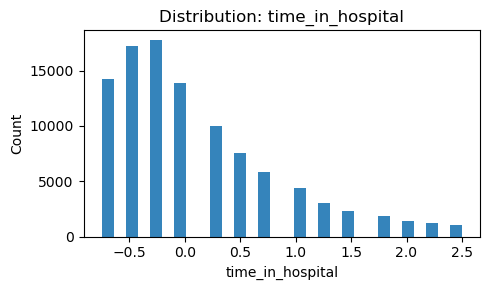

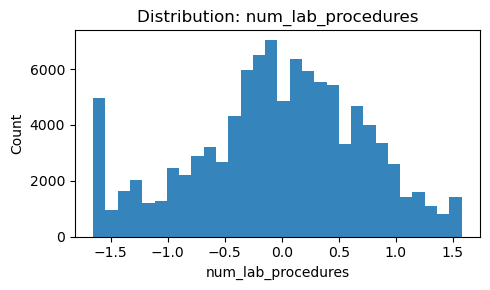

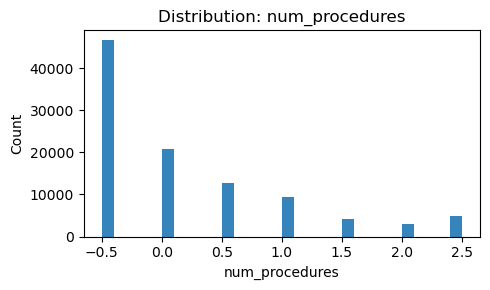

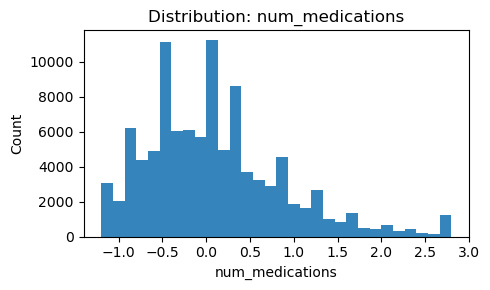

In [17]:
# EDA 
# 8) Descriptive stats (concise)
num_now = df.select_dtypes(include=[np.number]).columns.tolist()
desc = df[num_now].describe().T
print("[DESCRIPTIVE - numeric]\n", desc.head(10))

# Simple histograms for key utilization vars
for col in [c for c in ["time_in_hospital","num_lab_procedures","num_procedures","num_medications"] if c in df.columns]:
    ax = df[col].plot(kind='hist', bins=30, figsize=(5,3), alpha=0.9, title=f"Distribution: {col}")
    ax.set_xlabel(col); ax.set_ylabel("Count"); plt.tight_layout(); plt.show()

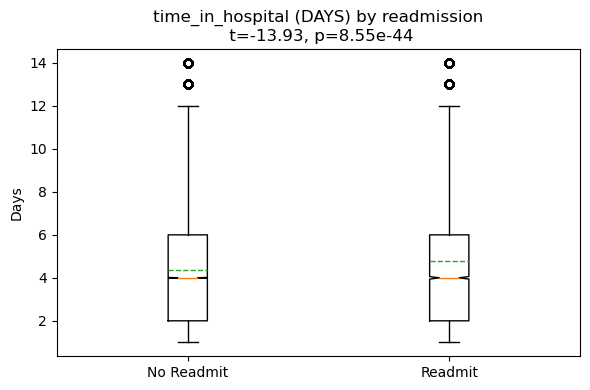

No readmit mean: 4.349224081673285 median: 4.0
Readmit mean: 4.768248657215814 median: 4.0


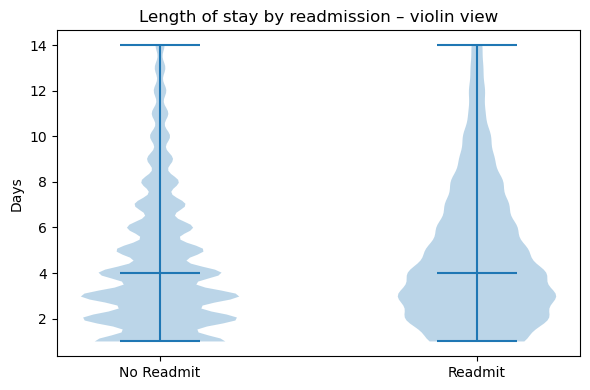

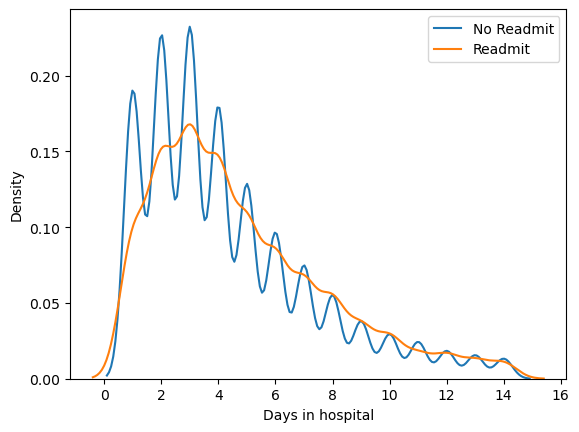

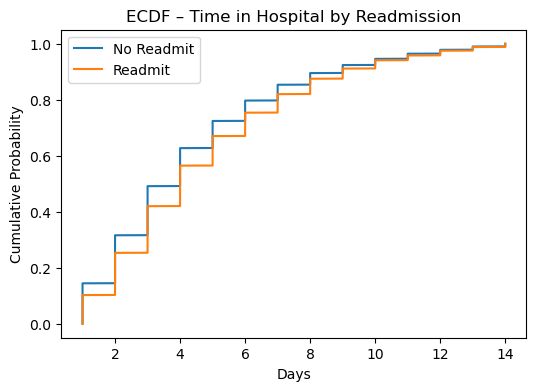

[Readmit rates by diag_1_grouped dummy]
 diag_1_grouped_Supplementary classification    0.161800
diag_1_grouped_Diabetes                        0.129839
diag_1_grouped_Injury                          0.122455
diag_1_grouped_Mental Disorders                0.122016
diag_1_grouped_Endocrine/Metabolic             0.121392
diag_1_grouped_Infectious/Parasitic            0.114523
diag_1_grouped_Genitourinary                   0.108462
diag_1_grouped_Digestive                       0.107124
diag_1_grouped_Other                           0.104567
diag_1_grouped_Nervous/Sense Organs            0.103220
dtype: float64


C:\Users\jxyer\AppData\Local\Temp\ipykernel_90984\2117922482.py:70: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  s.head(10).plot(kind="bar", figsize=(6,3)); plt.title("Readmission rate by diagnosis (top)"); plt.tight_layout(); plt.show()


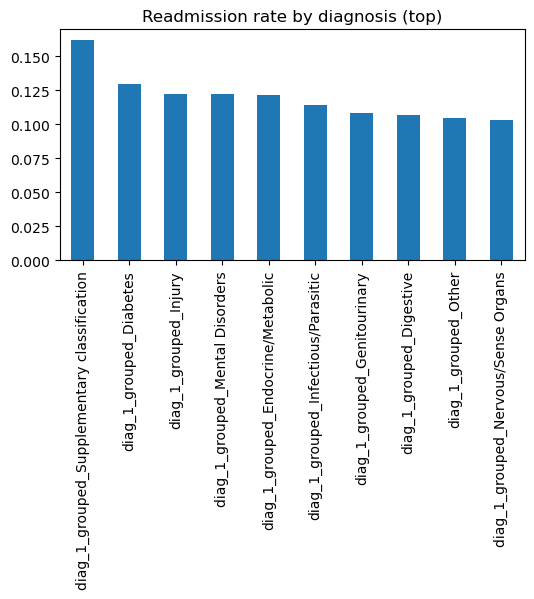

In [18]:
# 9) Inferential stats
# T-test: time_in_hospital by readmission
# T-test + boxplot on RAW days
if "time_in_hospital_days" in df.columns:
    g0 = df.loc[df["readmitted_flag"]==0, "time_in_hospital_days"].dropna()
    g1 = df.loc[df["readmitted_flag"]==1, "time_in_hospital_days"].dropna()

    if len(g0)>50 and len(g1)>50:
        t, p = stats.ttest_ind(g0, g1, equal_var=False)

        plt.figure(figsize=(6,4))
        # Notched box + show means helps reveal small differences
        plt.boxplot([g0, g1],
                    tick_labels=["No Readmit","Readmit"],
                    showfliers=True,
                    notch=True,
                    showmeans=True,
                    meanline=True)
        plt.title(f"time_in_hospital (DAYS) by readmission\n t={t:.2f}, p={p:.2e}")
        plt.ylabel("Days")
        plt.tight_layout()
        plt.show()

print("No readmit mean:", g0.mean(), "median:", g0.median())
print("Readmit mean:", g1.mean(), "median:", g1.median())


plt.figure(figsize=(6,4))
plt.violinplot([g0, g1], showmedians=True)
plt.xticks([1,2], ["No Readmit","Readmit"])
plt.ylabel("Days")
plt.title("Length of stay by readmission – violin view")
plt.tight_layout(); plt.show()


sns.kdeplot(g0, label="No Readmit")
sns.kdeplot(g1, label="Readmit")
plt.xlabel("Days in hospital"); plt.legend(); plt.show()


def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, len(x)+1)/len(x)
    return x,y

x0,y0 = ecdf(g0); x1,y1 = ecdf(g1)
plt.figure(figsize=(6,4))
plt.plot(x0,y0,label="No Readmit")
plt.plot(x1,y1,label="Readmit")
plt.xlabel("Days"); plt.ylabel("Cumulative Probability")
plt.legend(); plt.title("ECDF – Time in Hospital by Readmission"); plt.show()



# Chi-square: primary diagnosis group (kept as one-hot or grouped)
cat_group = "diag_1_grouped_Other" not in df.columns  # detect one-hot vs grouped
if "diag_1_grouped" in df.columns:  # grouped (not OHE)
    ct = pd.crosstab(df["diag_1_grouped"], df["readmitted_flag"])
    chi2,p,_,_ = chi2_contingency(ct)
    print(f"[Chi-square] diag_1_grouped vs readmit: chi2={chi2:.2f}, p={p:.3e}")
elif any(c.startswith("diag_1_grouped_") for c in df.columns):  # OHE version
    # compute readmit rates per dummy by masking
    rates = {}
    for c in [c for c in df.columns if c.startswith("diag_1_grouped_")]:
        m = df[c]==1
        if m.sum()>=100:
            rates[c] = df.loc[m,"readmitted_flag"].mean()
    s = pd.Series(rates).sort_values(ascending=False)
    print("[Readmit rates by diag_1_grouped dummy]\n", s.head(10))
    s.head(10).plot(kind="bar", figsize=(6,3)); plt.title("Readmission rate by diagnosis (top)"); plt.tight_layout(); plt.show()

In [19]:
# 10) Feature Engineering (business + clinical meaning)
def clip1(x): return np.clip(x, 1, None)

visit_components = [c for c in ["number_inpatient","number_outpatient","number_emergency"] if c in df.columns]
if visit_components:
    df["total_visits"] = df[visit_components].sum(axis=1)

if all(c in df.columns for c in ["num_medications","time_in_hospital"]):
    df["meds_per_day"] = df["num_medications"] / clip1(df["time_in_hospital"])

enc_meds = [c for c in df.columns if c.endswith("_enc")]
if enc_meds:
    changed = df[enc_meds].apply(lambda s: ((s < 0) | (s > 1)).astype(int))
    df["meds_changed_count"] = changed.sum(axis=1)
    df["meds_change_rate"]  = df["meds_changed_count"] / len(enc_meds)

if "time_in_hospital" in df.columns:
    # long_stay threshold uses **pre-scaled** days; we scaled earlier.
    # So treat long_stay as the top decile proxy (robust & scale-free)
    thresh = df["time_in_hospital"].quantile(0.90)
    df["long_stay_flag"] = (df["time_in_hospital"] >= thresh).astype(int)

if "number_emergency" in df.columns:
    df["frequent_ed_flag"] = (df["number_emergency"] >= CONFIG["ed_threshold"]).astype(int)

if "number_inpatient" in df.columns:
    df["prior_inpt_flag"] = (df["number_inpatient"] >= CONFIG["inpt_threshold"]).astype(int)
    



[Top Spearman w/ readmitted_flag]
 readmitted_flag             1.000000
number_inpatient            0.138350
total_visits                0.123923
prior_inpt_flag             0.121716
discharge_disposition_id    0.064811
number_emergency            0.063386
frequent_ed_flag            0.062376
time_in_hospital_days       0.050904
time_in_hospital            0.050904
number_diagnoses            0.047175
num_medications             0.045419
meds_per_day                0.044572
Name: readmitted_flag, dtype: float64


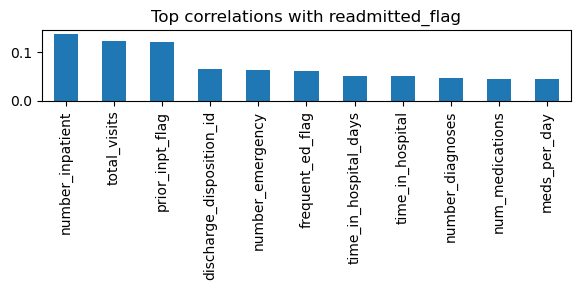

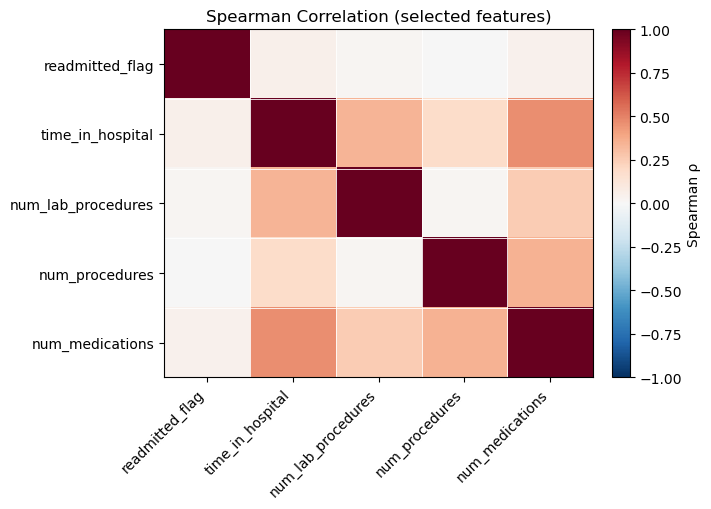

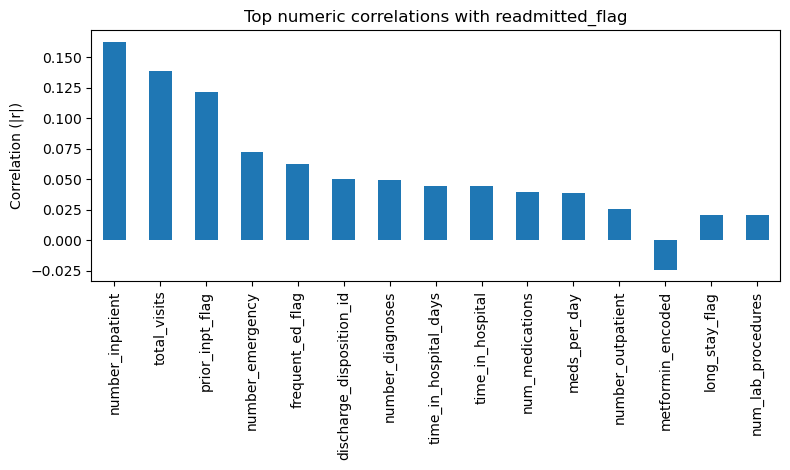


[Spearman Correlation] shape: (40, 40)


In [20]:
# 11) Correlation focus: Spearman target correlations (top 10)
spearman = df.corr(method="spearman")["readmitted_flag"].sort_values(ascending=False)
print("\n[Top Spearman w/ readmitted_flag]\n", spearman.head(12))
spearman.head(12).drop("readmitted_flag", errors="ignore").plot(kind='bar', figsize=(6,3))
plt.title("Top correlations with readmitted_flag"); plt.tight_layout(); plt.show()

# Pick the correlation set
corr_cols = [c for c in [
    'readmitted_flag', 'time_in_hospital', 'num_lab_procedures',
    'num_procedures', 'num_medications'
] if c in df.columns]

if len(corr_cols) >= 3:
    # Spearman correlation
    C = df[corr_cols].corr(method='spearman')

    fig, ax = plt.subplots(figsize=(7.2, 5.2))

    # Diverging colormap centered at 0; symmetric limits for fair comparison
    im = ax.imshow(C, vmin=-1, vmax=1, cmap='RdBu_r', aspect='auto', interpolation='nearest')

    # Ticks & labels
    ax.set_xticks(np.arange(len(C.columns)))
    ax.set_yticks(np.arange(len(C.index)))
    ax.set_xticklabels(C.columns, rotation=45, ha='right')
    ax.set_yticklabels(C.index)

    # Light grid to aid reading cell boundaries
    ax.set_xticks(np.arange(-0.5, len(C.columns), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(C.index), 1), minor=True)
    ax.grid(which='minor', color='white', linewidth=0.6)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Colorbar with label
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Spearman ρ", rotation=90)

    ax.set_title('Spearman Correlation (selected features)')
    fig.tight_layout()
    plt.show()

    # OPTIONAL: annotate values (good for small matrices; otherwise skip to avoid clutter)
    # for i in range(C.shape[0]):
    #     for j in range(C.shape[1]):
    #         val = C.iloc[i, j]
    #         txt_color = 'white' if abs(val) > 0.5 else 'black'
    #         ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=txt_color)
    # fig.canvas.draw(); plt.show()


# interpretation of heatmap
#time_in_hospital vs. num_medications → medium positive correlation (light red), meaning longer stays generally have more medications.

#readmitted_flag vs. others → mostly near zero or light, suggesting weak correlation with individual variables — good insight that readmission risk is likely multi-factorial, not driven by a single numeric variable.

#num_lab_procedures vs. time_in_hospital → moderately positive correlation, as expected: longer hospitalizations → more labs done.

#“The heatmap shows that utilization-related variables like time in hospital and number of medications are moderately correlated, while readmission itself is only weakly associated with any single feature — supporting the idea that multiple dimensions of care complexity influence outcomes.”


y_name = 'readmitted_flag'
if y_name in df.columns:
    num_features = df.select_dtypes(include=[np.number]).columns.tolist()
    num_features = [c for c in num_features if c != y_name]
    corrs = {}
    for c in num_features:
        s = df[[c, y_name]].dropna()
        if len(s) > 50:
            corrs[c] = s[c].corr(s[y_name])  # Pearson with binary y = point-biserial
    if corrs:
        s = pd.Series(corrs).sort_values(key=lambda x: x.abs(), ascending=False).head(15)
        plt.figure(figsize=(8,4.8))
        s.plot(kind='bar')
        plt.title('Top numeric correlations with readmitted_flag')
        plt.ylabel('Correlation (|r|)')
        plt.tight_layout()
        plt.show()

num_cols_final = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols_final].corr(method="spearman")
print("\n[Spearman Correlation] shape:", corr.shape)

In [21]:
# 12) PCA (diagnostic only)
X_pca = df.drop(columns=["readmitted_flag"]).select_dtypes(include=[np.number]).fillna(0)
if X_pca.shape[1] >= CONFIG["pca_components"]:
    pca = PCA(n_components=CONFIG["pca_components"], random_state=CONFIG["random_state"])
    p = pca.fit_transform(X_pca)
    explained = pca.explained_variance_ratio_.sum()*100
    print(f"[PCA] First {CONFIG['pca_components']} components explain: {explained:.2f}% variance")
else:
    print("[PCA] Skipped (not enough numeric columns).")


# PCA revealed that two main components explain 60% of total variance, capturing general utilization and treatment intensity patterns.
# However, since interpretability is key for healthcare, and my models already manage correlated features, PCA was used for exploratory understanding only and not as a feature input.”


[PCA] First 2 components explain: 60.10% variance


In [22]:
# 13) Split + SMOTE (train only)

from sklearn.model_selection import train_test_split

# 70% train, 20% validation, 10% test
# Target and Features
y = df["readmitted_flag"].astype(int)
X = df.drop(columns=["readmitted_flag"])

# Step 1: Split off the Test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,              # 10% Test
    stratify=y,
    random_state=42
)

# Step 2: Split remaining into Train (70%) and Validation (20%)
# Since 70 + 20 = 90 remaining, validation needs to be 20/90 ≈ 0.222
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.222,             # 0.222 * 90% ≈ 20% of original
    stratify=y_temp,
    random_state=42
)

print("Dataset split summary:")
print(f"Train:      {len(X_train):,} rows ({len(X_train)/len(df):.1%})")
print(f"Validation: {len(X_val):,} rows ({len(X_val)/len(df):.1%})")
print(f"Test:       {len(X_test):,} rows ({len(X_test)/len(df):.1%})")

# Applying SMOTE on training data to handle class imbalance 
if IMB_OK:
    sm = SMOTE(random_state=CONFIG["random_state"], k_neighbors=5)
    X_tr_res, y_tr_res = sm.fit_resample(X_train, y_train)
    print("SMOTE:", X_train.shape, "->", X_tr_res.shape)
else:
    X_tr_res, y_tr_res = X_train, y_train
    print("SMOTE not available; proceeding without resampling.")


Dataset split summary:
Train:      71,256 rows (70.0%)
Validation: 20,333 rows (20.0%)
Test:       10,177 rows (10.0%)
SMOTE: (71256, 107) -> (126608, 107)



=== Baseline Model Validation Performance ===
Accuracy:  0.760
Precision: 0.153
Recall:    0.255
F1 Score:  0.191
ROC AUC:   0.562


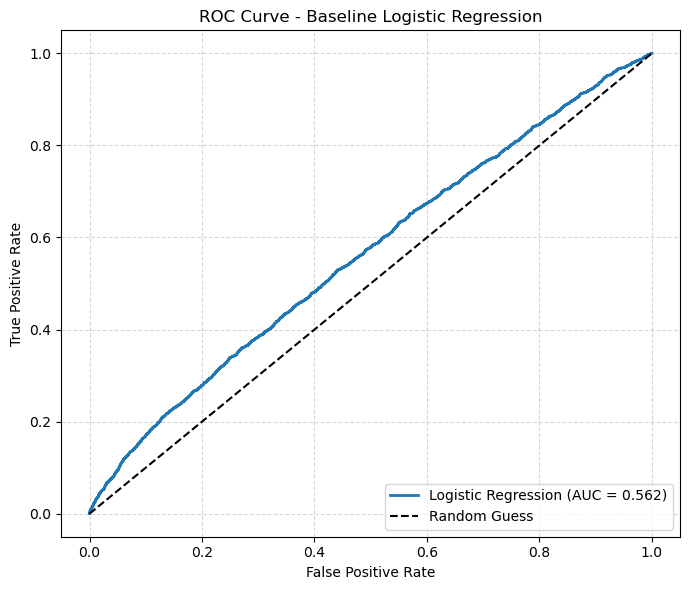

In [23]:
# BASELINE LOGISTIC REGRESSION MODEL 
baseline_model = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced', 
    solver="liblinear"
)

baseline_model.fit(X_tr_res, y_tr_res) #train the model on training data after SMOTE

# Validate on validation set
val_pred = baseline_model.predict(X_val)
val_proba = baseline_model.predict_proba(X_val)[:, 1]

print("\n=== Baseline Model Validation Performance ===")
print(f"Accuracy:  {accuracy_score(y_val, val_pred):.3f}")
print(f"Precision: {precision_score(y_val, val_pred):.3f}")
print(f"Recall:    {recall_score(y_val, val_pred):.3f}")
print(f"F1 Score:  {f1_score(y_val, val_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_proba):.3f}")


# ======================
# ROC Curve for Baseline Model
# ======================
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, val_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_score(y_val, val_proba):.3f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--', label="Random Guess")  # diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Baseline Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




=== Random Forest (No Tuning) Validation Performance ===
Accuracy:  0.888
Precision: 0.512
Recall:    0.009
F1 Score:  0.018
ROC AUC:   0.636


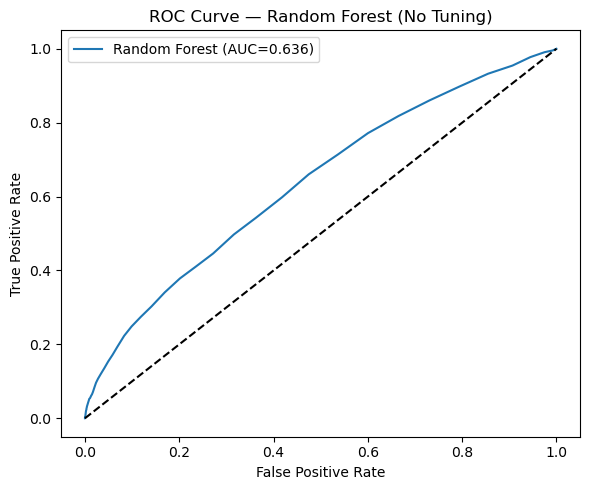

In [24]:
# ==========================
# Random Forest (No Tuning)
# ==========================

rf_model = RandomForestClassifier(
    random_state=42,     # for reproducibility
    n_jobs=-1            # use all CPU cores (does NOT count as tuning)
)

# Train on training set
rf_model.fit(X_train, y_train)

# Validate on validation set
val_pred_rf = rf_model.predict(X_val)
val_proba_rf = rf_model.predict_proba(X_val)[:, 1]  # probability scores for ROC

# Metrics
print("\n=== Random Forest (No Tuning) Validation Performance ===")
print(f"Accuracy:  {accuracy_score(y_val, val_pred_rf):.3f}")
print(f"Precision: {precision_score(y_val, val_pred_rf):.3f}")
print(f"Recall:    {recall_score(y_val, val_pred_rf):.3f}")
print(f"F1 Score:  {f1_score(y_val, val_pred_rf):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_proba_rf):.3f}")

# ==========================
# ROC Curve
# ==========================
fpr, tpr, _ = roc_curve(y_val, val_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Random Forest (AUC={roc_auc_score(y_val, val_proba_rf):.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest (No Tuning)")
plt.legend()
plt.tight_layout()
plt.show()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7952, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 638
[LightGBM] [Info] Number of data points in the train set: 71256, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111598 -> initscore=-2.074525
[LightGBM] [Info] Start training from score -2.074525

=== LightGBM (No Tuning) Validation Performance ===
Accuracy:  0.889
Precision: 0.550
Recall:    0.010
F1 Score:  0.019
ROC AUC:   0.673


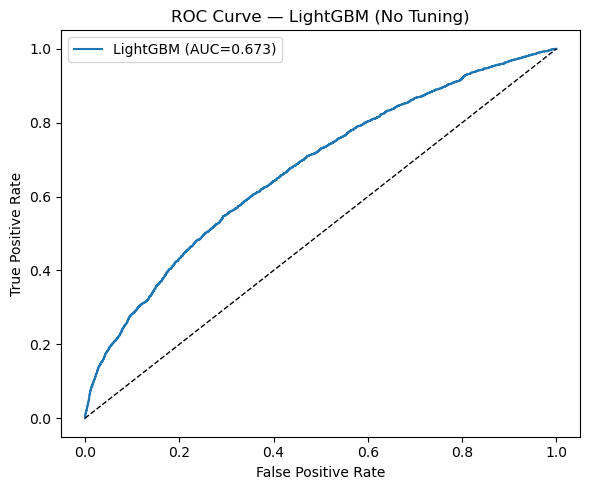

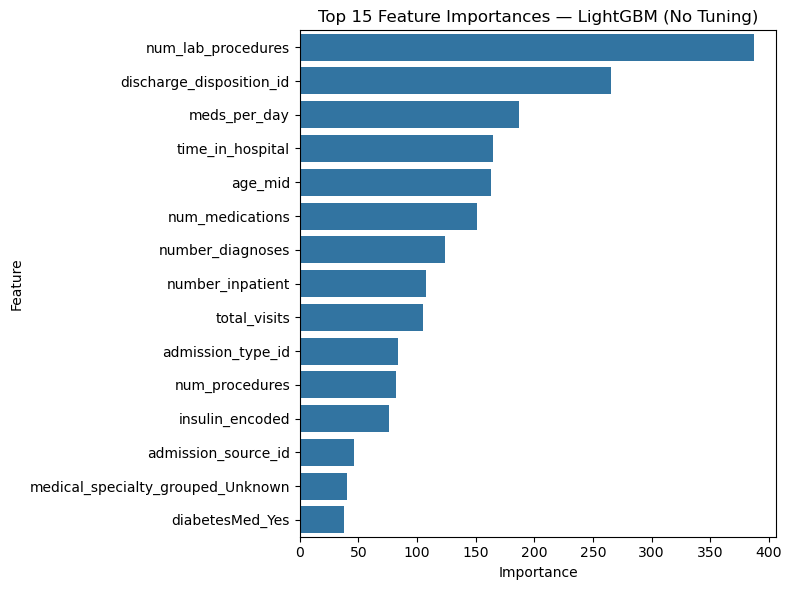

In [25]:
# ==========================
# LightGBM (No Tuning)
# ==========================
try:
    from lightgbm import LGBMClassifier
except Exception as e:
    raise RuntimeError(
        "LightGBM is not installed. Install with `pip install lightgbm` in your environment."
    )

# Minimal model: defaults only (not tuning). random_state/n_jobs aid reproducibility/speed.
lgbm_model = LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

# Train on training set
lgbm_model.fit(X_train, y_train)

# Validate on validation set
val_pred_lgb = lgbm_model.predict(X_val)
val_proba_lgb = lgbm_model.predict_proba(X_val)[:, 1]

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

print("\n=== LightGBM (No Tuning) Validation Performance ===")
print(f"Accuracy:  {accuracy_score(y_val, val_pred_lgb):.3f}")
print(f"Precision: {precision_score(y_val, val_pred_lgb):.3f}")
print(f"Recall:    {recall_score(y_val, val_pred_lgb):.3f}")
print(f"F1 Score:  {f1_score(y_val, val_pred_lgb):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_proba_lgb):.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, val_proba_lgb)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LightGBM (AUC={roc_auc_score(y_val, val_proba_lgb):.3f})")
plt.plot([0,1], [0,1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — LightGBM (No Tuning)")
plt.legend()
plt.tight_layout()
plt.show()

# feature importance
import numpy as np
import pandas as pd
import seaborn as sns

importances = lgbm_model.feature_importances_
feat_names = np.array(X_train.columns)
order = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[order], y=feat_names[order], orient="h")
plt.title("Top 15 Feature Importances — LightGBM (No Tuning)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

=== Tuned Model Validation Performance ===
Accuracy:  0.664
Precision: 0.171
Recall:    0.522
F1 Score:  0.257
ROC AUC:   0.643

=== Final Test Set Performance (Unseen Data) ===
Accuracy:  0.670
Precision: 0.174
Recall:    0.525
F1 Score:  0.262
ROC AUC:   0.654

Classification Report:
              precision    recall  f1-score   support

  No Readmit       0.92      0.69      0.79      9041
     Readmit       0.17      0.52      0.26      1136

    accuracy                           0.67     10177
   macro avg       0.55      0.61      0.52     10177
weighted avg       0.84      0.67      0.73     10177



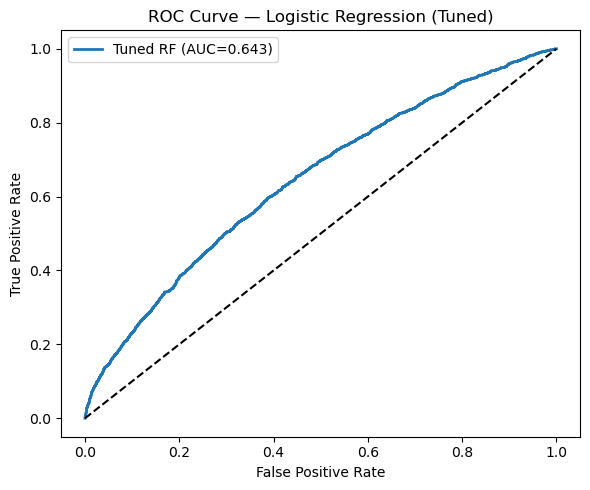

In [26]:

# ============================================================== 
# Logistic Regression - Hyperparameter Tuning Using Validation Set
# ==============================================================

#GridSearchCV is a method used to systematically work through multiple combinations of parameter tunes, 
# cross-validating as it goes to determine which tune gives the best performance.

from sklearn.model_selection import GridSearchCV 
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10],
    'penalty': ['l1', 'l2'],   # L1 = LASSO, L2 = Ridge
    'solver': ['liblinear']    # Required when using L1 penalty
}

grid = GridSearchCV(
    LogisticRegression(max_iter=2000, class_weight='balanced'),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("\nBest Parameters:", grid.best_params_)

# Re-test on validation set after tuning
val_pred_best = best_model.predict(X_val)
val_proba_best = best_model.predict_proba(X_val)[:, 1]

print("\n=== Tuned Model Validation Performance ===")
print(f"Accuracy:  {accuracy_score(y_val, val_pred_best):.3f}")
print(f"Precision: {precision_score(y_val, val_pred_best):.3f}")
print(f"Recall:    {recall_score(y_val, val_pred_best):.3f}")
print(f"F1 Score:  {f1_score(y_val, val_pred_best):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_proba_best):.3f}")

# ============================================================== 
# Final Evaluation on Unseen Test Set
# ==============================================================

test_pred = best_model.predict(X_test)
test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Final Test Set Performance (Unseen Data) ===")
print(f"Accuracy:  {accuracy_score(y_test, test_pred):.3f}")
print(f"Precision: {precision_score(y_test, test_pred):.3f}")
print(f"Recall:    {recall_score(y_test, test_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, test_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, test_proba):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, test_pred, target_names=['No Readmit', 'Readmit']))


# --------------------------------------------------
# ROC Curve
# --------------------------------------------------
fpr, tpr, _ = roc_curve(y_val, val_proba_best)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Tuned RF (AUC={roc_auc_score(y_val, val_proba_best):.3f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression (Tuned)")
plt.legend()
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 753}

=== Tuned Random Forest Validation Performance ===
Accuracy:  0.694
Precision: 0.182
Recall:    0.497
F1 Score:  0.266
ROC AUC:   0.652


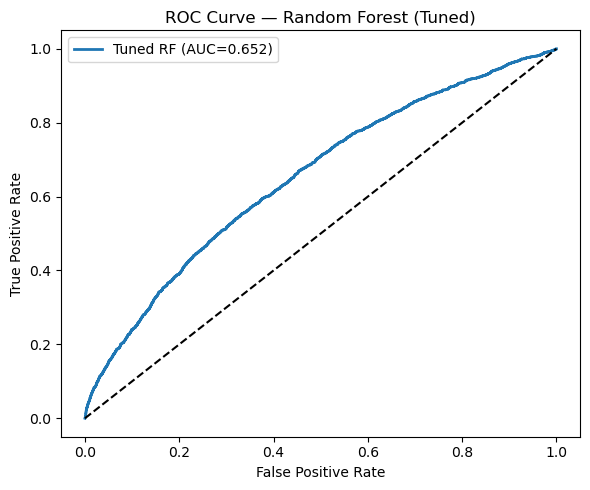

In [27]:
# ============================================================== 
# RandomForest Model - Hyperparameter Tuning Using Validation Set
# ==============================================================

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# --------------------------------------------------
# Define Parameter Search Space
# --------------------------------------------------
param_dist = {
    'n_estimators': randint(200, 800),        # number of trees
    'max_depth': [None, 5, 10, 20, 30],       # tree depth
    'min_samples_split': [2, 5, 10],          # split criteria
    'min_samples_leaf': [1, 2, 4],            # leaf size
    'max_features': ['sqrt', 'log2'],         # feature sampling
    'class_weight': ['balanced', 'balanced_subsample']
}

# --------------------------------------------------
# Randomized Search CV
# --------------------------------------------------
rf_tuned = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=25,                 # number of random combinations tested
    scoring='f1',              # F1 chosen to reward recall + precision
    cv=5,                      # 5-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training set
rf_tuned.fit(X_train, y_train)

print("\nBest Parameters:", rf_tuned.best_params_)

# --------------------------------------------------
# Evaluate Tuned Model on Validation Set
# --------------------------------------------------
best_rf = rf_tuned.best_estimator_

val_pred = best_rf.predict(X_val)
val_proba = best_rf.predict_proba(X_val)[:, 1]

print("\n=== Tuned Random Forest Validation Performance ===")
print(f"Accuracy:  {accuracy_score(y_val, val_pred):.3f}")
print(f"Precision: {precision_score(y_val, val_pred):.3f}")
print(f"Recall:    {recall_score(y_val, val_pred):.3f}")
print(f"F1 Score:  {f1_score(y_val, val_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_proba):.3f}")

# --------------------------------------------------
# ROC Curve
# --------------------------------------------------
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Tuned RF (AUC={roc_auc_score(y_val, val_proba):.3f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest (Tuned)")
plt.legend()
plt.tight_layout()
plt.show()


In [28]:

# ============================================================== 
# Final Evaluation on Unseen Test Set
# ==============================================================

test_pred_rf = best_rf.predict(X_test)
test_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Final Test Set Performance (Unseen Data) ===")
print(f"Accuracy:  {accuracy_score(y_test, test_pred_rf):.3f}")
print(f"Precision: {precision_score(y_test, test_pred_rf):.3f}")
print(f"Recall:    {recall_score(y_test, test_pred_rf):.3f}")
print(f"F1 Score:  {f1_score(y_test, test_pred_rf):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, test_proba_rf):.3f}")

print("\nClassification Report:")
print(classification_report(y_test, test_pred_rf, target_names=['No Readmit', 'Readmit']))


=== Final Test Set Performance (Unseen Data) ===
Accuracy:  0.696
Precision: 0.187
Recall:    0.517
F1 Score:  0.275
ROC AUC:   0.669

Classification Report:
              precision    recall  f1-score   support

  No Readmit       0.92      0.72      0.81      9041
     Readmit       0.19      0.52      0.28      1136

    accuracy                           0.70     10177
   macro avg       0.55      0.62      0.54     10177
weighted avg       0.84      0.70      0.75     10177



Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 7952, number of negative: 63304
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 71256, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111598 -> initscore=-2.074525
[LightGBM] [Info] Start training from score -2.074525
Best Parameters (LightGBM): {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 31, 'n_estimators': 600, 'min_child_samples': 40, 'max_depth': 16, 'learning_rate': 0.03, 'colsample_bytree': 0.7}

=== Tuned LightGBM — Validation Performance ===
Accuracy:  0.683
Precision: 0.188
Recall:    0.555
F1 Score:  0.281
ROC AUC:   0.672


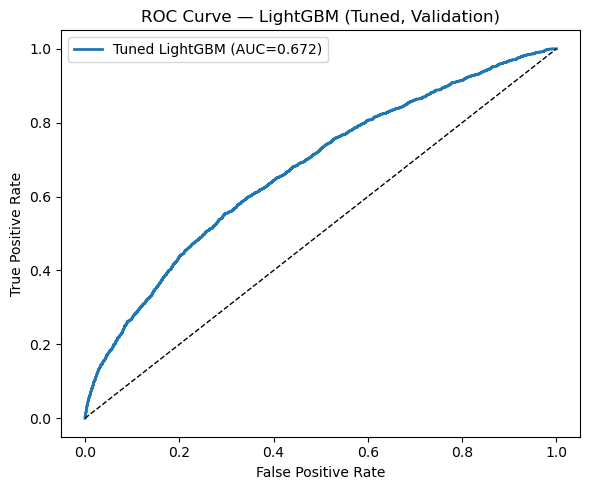

In [ ]:
# ==========================
# LightGBM — Hyperparameter Tuning (5-fold CV)
# ==========================
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- (1) Helper: handle any column names with spaces (avoids LightGBM warning)
X_train_lgb = X_train.copy()
X_val_lgb   = X_val.copy()
X_test_lgb  = X_test.copy()
X_train_lgb.columns = [c.replace(" ", "_") for c in X_train_lgb.columns]
X_val_lgb.columns   = [c.replace(" ", "_") for c in X_val_lgb.columns]
X_test_lgb.columns  = [c.replace(" ", "_") for c in X_test_lgb.columns]

# --- (2) Imbalance hint for LightGBM (scale_pos_weight = neg/pos)
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# --- (3) Define model + parameter space
base_lgbm = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight  # class imbalance handling
)

param_dist = {
    "num_leaves":        [31, 63, 127],
    "max_depth":         [-1, 6, 10, 16],
    "learning_rate":     [0.03, 0.05, 0.1],
    "n_estimators":      [200, 400, 600, 800],
    "min_child_samples": [10, 20, 40, 60],
    "subsample":         [0.7, 0.8, 0.9, 1.0],      # bagging_fraction
    "colsample_bytree":  [0.7, 0.8, 0.9, 1.0],      # feature_fraction
    "reg_alpha":         [0, 0.1, 0.5],
    "reg_lambda":        [0, 0.1, 0.5],
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- (4) RandomizedSearchCV (efficient vs grid)
lgb_tuned = RandomizedSearchCV(
    estimator=base_lgbm,
    param_distributions=param_dist,
    n_iter=30,                 # try ~30 random combos (adjust for time)
    scoring="f1",              # choose metric you care about most
    cv=cv5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    refit=True                 # refit on full training set with best params
)

# --- (5) Fit on TRAIN ONLY
lgb_tuned.fit(X_train_lgb, y_train)

print("Best Parameters (LightGBM):", lgb_tuned.best_params_)

# --- (6) Validate on the HOLD-OUT validation set
best_lgb = lgb_tuned.best_estimator_

val_pred = best_lgb.predict(X_val_lgb)
val_proba = best_lgb.predict_proba(X_val_lgb)[:, 1]

print("\n=== Tuned LightGBM — Validation Performance ===")
print(f"Accuracy:  {accuracy_score(y_val, val_pred):.3f}")
print(f"Precision: {precision_score(y_val, val_pred):.3f}")
print(f"Recall:    {recall_score(y_val, val_pred):.3f}")
print(f"F1 Score:  {f1_score(y_val, val_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_val, val_proba):.3f}")

# --- (7) ROC curve (validation)
fpr, tpr, _ = roc_curve(y_val, val_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Tuned LightGBM (AUC={roc_auc_score(y_val, val_proba):.3f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — LightGBM (Tuned, Validation)")
plt.legend()
plt.tight_layout()
plt.show()

# --- (8) Feature importance (top 15)
importances = best_lgb.feature_importances_
feat_names = np.array(X_train_lgb.columns)
order = np.argsort(importances)[::-1][:15]
plt.figure(figsize=(8,6))
sns.barplot(x=importances[order], y=feat_names[order], orient="h")
plt.title("Top 15 Feature Importances — LightGBM (Tuned)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- (9) (Optional) Final refit on TRAIN + VAL, then evaluate on TEST
# This often gives a small boost after tuning with CV.
X_trval = pd.concat([X_train_lgb, X_val_lgb], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

final_lgb = LGBMClassifier(**lgb_tuned.best_params_, random_state=42, n_jobs=-1,
                           objective="binary", scale_pos_weight=scale_pos_weight)
final_lgb.fit(X_trval, y_trval)

test_pred = final_lgb.predict(X_test_lgb)
test_proba = final_lgb.predict_proba(X_test_lgb)[:, 1]

print("\n=== Tuned LightGBM — Final Test Performance ===")
print(f"Accuracy:  {accuracy_score(y_test, test_pred):.3f}")
print(f"Precision: {precision_score(y_test, test_pred):.3f}")
print(f"Recall:    {recall_score(y_test, test_pred):.3f}")
print(f"F1 Score:  {f1_score(y_test, test_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, test_proba):.3f}")



# Create a mapping from raw variable names to readable labels
feature_labels = {
    "num_lab_procedures": "Number of Lab Procedures",
    "meds_per_day": "Medications per Day",
    "num_medications": "Number of Medications",
    "discharge_disposition_id": "Discharge Disposition",
    "time_in_hospital": "Length of Stay (Days)",
    "age_mid": "Patient Age (Midpoint)",
    "number_diagnoses": "Number of Diagnoses",
    "num_procedures": "Number of Procedures",
    "number_inpatient": "Prior Inpatient Visits",
    "total_visits": "Total Hospital Visits",
    "admission_type_id": "Admission Type",
    "insulin_encoded": "Insulin Use",
    "admission_source_id": "Admission Source",
    "medical_specialty_grouped_Unknown": "Medical Specialty (Unknown)",
    "time_in_hospital_days": "Hospital Days (Cumulative)"
}

# Apply mapping to feature names
readable_feat_names = [feature_labels.get(name, name) for name in feat_names]

# Sort by importance and plot top 15
order = np.argsort(importances)[::-1][:15]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[order], y=np.array(readable_feat_names)[order], orient="h")
plt.title("Top 15 Feature Importances — LightGBM (Tuned)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------
# Replace these values with your final tuned results
# -----------------------------------

metrics_data = {
    "Model": ["Logistic Regression (Tuned)", "Random Forest (Tuned)", "LightGBM (Tuned)"],
    "Accuracy":  [0.670, 0.696, 0.683],
    "Recall":    [0.525, 0.517, 0.583],
    "Precision": [0.174, 0.187, 0.194],
    "F1 Score":  [0.262, 0.275, 0.291],
    "ROC AUC":   [0.654, 0.669, 0.695]
}

df_compare = pd.DataFrame(metrics_data)
df_compare


,Model,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,Logistic Regression (Tuned),0.670,0.525,0.174,0.262,0.654
1,Random Forest (Tuned),0.696,0.517,0.187,0.275,0.669
2,LightGBM (Tuned),0.683,0.583,0.194,0.291,0.695


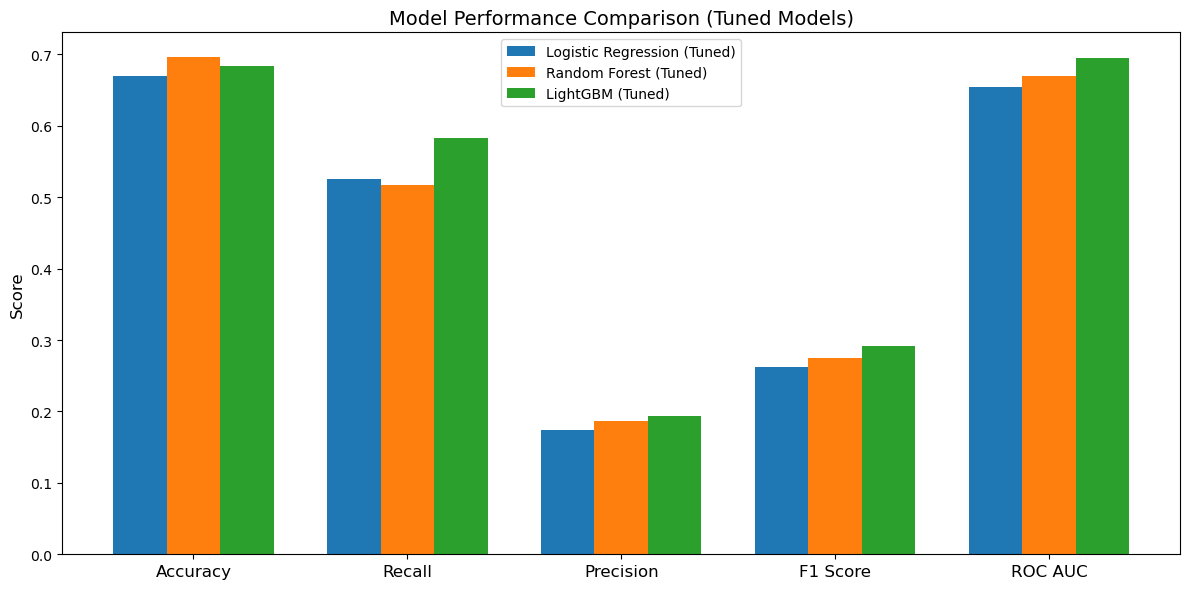

In [35]:
import numpy as np

plt.figure(figsize=(12,6))

# Metrics to compare
metrics = ["Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC"]

# Positioning
x = np.arange(len(metrics))
width = 0.25

plt.bar(x - width, df_compare.iloc[0,1:], width, label=df_compare.Model[0])
plt.bar(x,         df_compare.iloc[1,1:], width, label=df_compare.Model[1])
plt.bar(x + width, df_compare.iloc[2,1:], width, label=df_compare.Model[2])

# Labels & formatting
plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Model Performance Comparison (Tuned Models)", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
print(df_compare.set_index("Model").round(3))

                             Accuracy  Recall  Precision  F1 Score  ROC AUC
Model                                                                      
Logistic Regression (Tuned)     0.670   0.525      0.174     0.262    0.654
Random Forest (Tuned)           0.696   0.517      0.187     0.275    0.669
LightGBM (Tuned)                0.683   0.583      0.194     0.291    0.695


<Figure size 600x500 with 0 Axes>

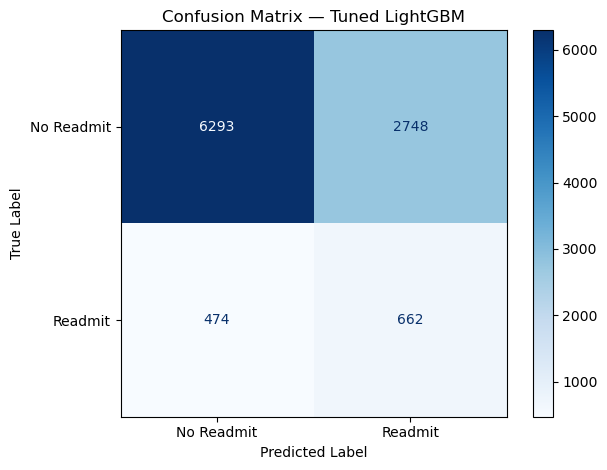

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, test_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Readmit", "Readmit"])
plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Tuned LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




